<a href="https://colab.research.google.com/github/Squirtle007/Retrieval-Augmented_Generation/blob/main/Retrieval_Augmented_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install all necessary packages
!pip install langchain==0.2.1 langchain-community==0.2.1 langchain-nvidia-ai-endpoints==0.0.18 unstructured==0.14.2 unstructured[pdf]==0.14.2 fastapi==0.109.0 kaleido==0.2.1 uvicorn==0.27.0 sentence-transformers==2.2.2 chromadb==0.4.22 huggingface_hub==0.25.2
%reset -sf

# **RAG with NVIDIA AI Foundation Models**

[**NGC**](https://catalog.ngc.nvidia.com/) allows developers to experience state-of-the-art LLMs accelerated on NVIDIA DGX Cloud with NVIDIA TensorRT and Triton Inference Server. Developers get **free credits for 10K requests** to any of the available models.

Sign up for free credits, follow the [**instructions**](https://github.com/Squirtle007/Retrieval-Augmented_Generation/blob/main/README.md) and paste your API key into the following cell:



In [ ]:
import os

os.environ['NVIDIA_API_KEY'] = "Paste your API key here!!!"

This notebook demonstrates how to use LangChain(https://python.langchain.com/docs/get_started/introduction) and NVIDIA AI Foundation Models to build a chatbot that references a custom knowledge-base.

Suppose you have some text documents (PDF, blog, Notion pages, etc.) and want to ask questions related to the contents of those documents. LLMs, given their proficiency in understanding text, are a great tool for this.

![](https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/rag-pipeline-ingest-query-flow-b.png)

### Part I: Load Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
LangChain provides a variety of [document loaders](https://python.langchain.com/docs/integrations/document_loaders) that load various types of documents (HTML, PDF, code) from many different sources and locations (private s3 buckets, public websites).

Document loaders load data from a source as **Documents**. A **Document** is a piece of text (the page_content) and associated metadata. Document loaders provide a ``load`` method for loading data as documents from a configured source.

In this example, we use a LangChain [`UnstructuredFileLoader`](https://python.langchain.com/docs/integrations/document_loaders/unstructured_file) to load a research paper about Llama2 from Meta.

[Here](https://python.langchain.com/docs/integrations/document_loaders) are some of the other document loaders available from LangChain.

In [ ]:
!wget -O "ChipNeMo.pdf" -nc --user-agent="Mozilla" https://d1qx31qr3h6wln.cloudfront.net/publications/ChipNeMo%20%282%29.pdf

File ‘ChipNeMo.pdf’ already there; not retrieving.


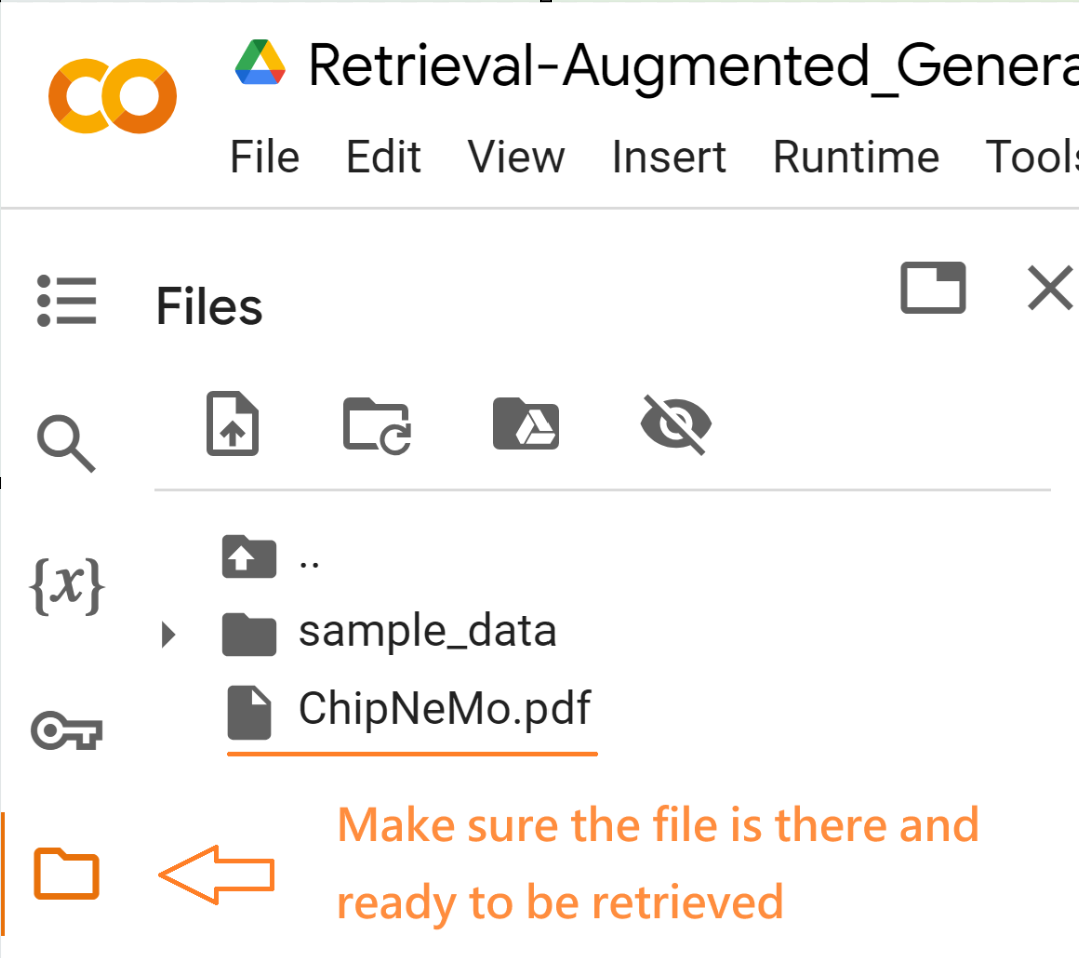

In [ ]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("ChipNeMo.pdf")
data = loader.load()

### Part II: Transform Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
Once documents have been loaded, they are often transformed. One method of transformation is known as **chunking**, which breaks down large pieces of text, for example, a long document, into smaller segments. This technique is valuable because it helps [optimize the relevance of the content returned from the vector database](https://www.pinecone.io/learn/chunking-strategies/).

<img src=""
     align="left"
     width="500" />



LangChain provides a [variety of document transformers](https://python.langchain.com/docs/integrations/document_transformers/), such as text splitters. In this example, we use a [``SentenceTransformersTokenTextSplitter``](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.SentenceTransformersTokenTextSplitter.html#langchain.text_splitter.SentenceTransformersTokenTextSplitter). The ``SentenceTransformersTokenTextSplitter`` is a specialized text splitter for use with the sentence-transformer models. The default behaviour is to split the text into chunks that fit the token window of the sentence transformer model that you would like to use. This sentence transformer model is used to generate the embeddings from documents.

Chunking is crucial for semantic search and RAG. It ensures coherence and context in responses. Disconnected content can lead to loss of coherence. You can customize **chunk size** and **chunk overlap** based on the document and analysis purpose.

In [ ]:
import time
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

TEXT_SPLITTER_CHUNCK_SIZE = 510
TEXT_SPLITTER_CHUNCK_OVERLAP = 200

text_splitter = SentenceTransformersTokenTextSplitter(
    chunk_size=TEXT_SPLITTER_CHUNCK_SIZE,
    chunk_overlap=TEXT_SPLITTER_CHUNCK_OVERLAP,
)
start_time = time.time()
documents = text_splitter.split_documents(data)
print(f"--- {time.time() - start_time} seconds ---")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

--- 4.831380128860474 seconds ---


### Part III: Generate Embeddings and Store Embeddings in the Vector Store [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
#### a) Store Document Embeddings in the Vector Store
Once the document embeddings are generated, they are stored in a vector store so that at query time we can:
(1) Embed the user query and
(2) Retrieve the embedding vectors that are most similar to the embedding query.

A vector store takes care of storing the embedded data and performing a vector search.

LangChain provides support for a [great selection of vector stores](https://python.langchain.com/docs/integrations/vectorstores/).

<div class="alert alert-block alert-info">
    
⚠️ For this workflow, [chroma](https://www.trychroma.com/) is used for vector database (DB)

</div>

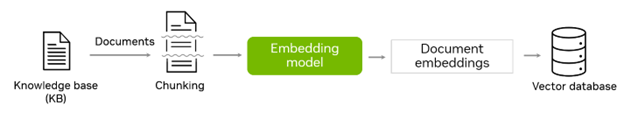

#### b) Generate Embeddings
[Embeddings](https://python.langchain.com/docs/modules/data_connection/text_embedding/) for documents are created by vectorizing the document text; this vectorization captures the semantic meaning of the text. This allows you to quickly and efficiently find other pieces of text that are similar. The embedding model used below is [intfloat/e5-large-v2](https://huggingface.co/intfloat/e5-large-v2).
When a user sends their query, the query is also embedded using the same embedding model that was used to embed the documents. This helps find similar or relevant documents to the user's query.

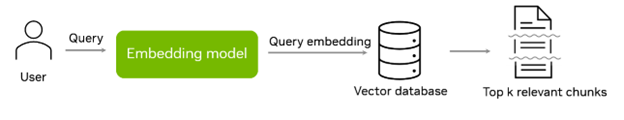

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import torch
import time

embedding_model = "intfloat/e5-large-v2"
model_kwargs = {"device": "cuda:0"}    #Change to {"device": "cpu"} for CPU implementation
encode_kwargs = {"normalize_embeddings": False}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)
start_time = time.time()
vectorstore = Chroma.from_documents(documents, hf_embeddings)
print(f"--- {time.time() - start_time} seconds ---")

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

handler.py:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

--- 10.440955638885498 seconds ---


Note that running the embedding model on an **NVIDIA GPU** (T4) is significantly faster than on a CPU:

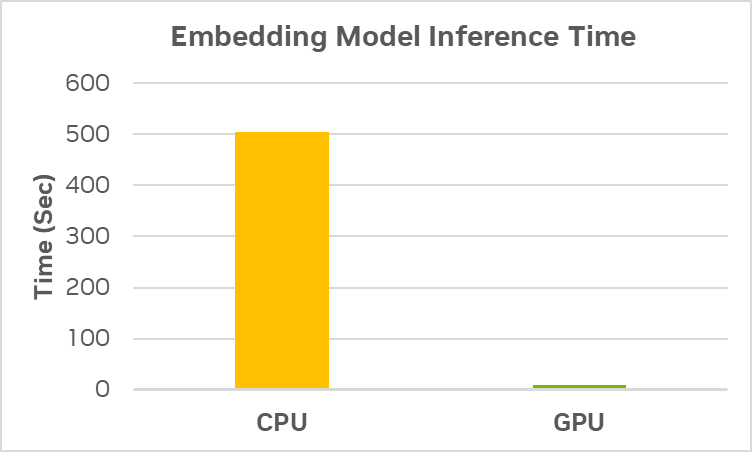


### Part IV: Access NVIDIA AI Foundation Models

Let's explore powerful Large Language Models (LLMs) on NVIDIA AI Foundation Models. Try out the **"mixtral_8x7B"** model in this example.
The **ChatNVIDIA** is a chat model that connects to NVIDIA AI Foundation Endpoints. The model and its corresponding hyperparameters can be customized. For instance, you can adjust the **temperature** setting to control the randomness of the model's output.

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import StrOutputParser

foundation_model="ai-llama3-8b" # Or use ChatNVIDIA.get_available_models() to get a list of available models.
llm = ChatNVIDIA(model=foundation_model, temperature=0.1, max_tokens=100, top_p=1.0)| StrOutputParser()

### Part V: Ask a question without context

Send request to the LLM without any context from the vector DB. The answer is generic and irrelvant.

In [ ]:
question = "What is ChipNeMo?"

answer = llm.invoke(question)
print(answer)

ChipNeMo is not a widely known term or concept, and I was unable to find any specific information about it through a quick online search. It is possible that ChipNeMo is a typo or a specific term that is used in a certain context or industry.

Without more context, it is difficult to provide a precise definition of ChipNeMo. However, based on the individual words that make up the term, it could potentially be related to semiconductor chips or neuromorphic computing, which involves the design of computer systems that are inspired by the structure and function of the human brain.

If you have more information about ChipNeMo or the context in which it is used, I may be able to provide a more accurate answer.


The following cell is optional for prompting the LLM. For example, it can be used to stop the model when uncertain knowledge is encountered.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [("system", "If uncertain about the answer, admit you don't know. Otherwise, feel free to answer."), ("user", "{input}")]
)
chain = prompt | ChatNVIDIA(model=foundation_model) | StrOutputParser()

for txt in chain.stream({"input": question}):
    print(txt, end="")

ChipNeMo is not a term or concept that I am currently aware of. A search of several databases and sources has not provided any relevant information about ChipNeMo. I am confident in my ability to provide information on a wide range of topics, but I must admit that I do not have any knowledge about ChipNeMo.

### Part VI: Compose a streamed answer using a Chain
NVIDIA integrated [**TensorRT-LLM**](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-supercharges-large-language-model-inference-on-nvidia-h100-gpus/) into [LangChain chain](https://python.langchain.com/docs/modules/chains/), handling document loading, transformation, embedding generation, and storage.



To complete the pipeline, we use a [RetrievalQA chain](https://js.langchain.com/docs/modules/chains/popular/vector_db_qa/), which is a chain type for question-answering against a vector index. It combines using a *Retrieval* and *question-answering (QA) chain*.

Note that [**TensorRT-LLM**](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-supercharges-large-language-model-inference-on-nvidia-h100-gpus/) significantly boosts the inference efficiency for the foundation model:

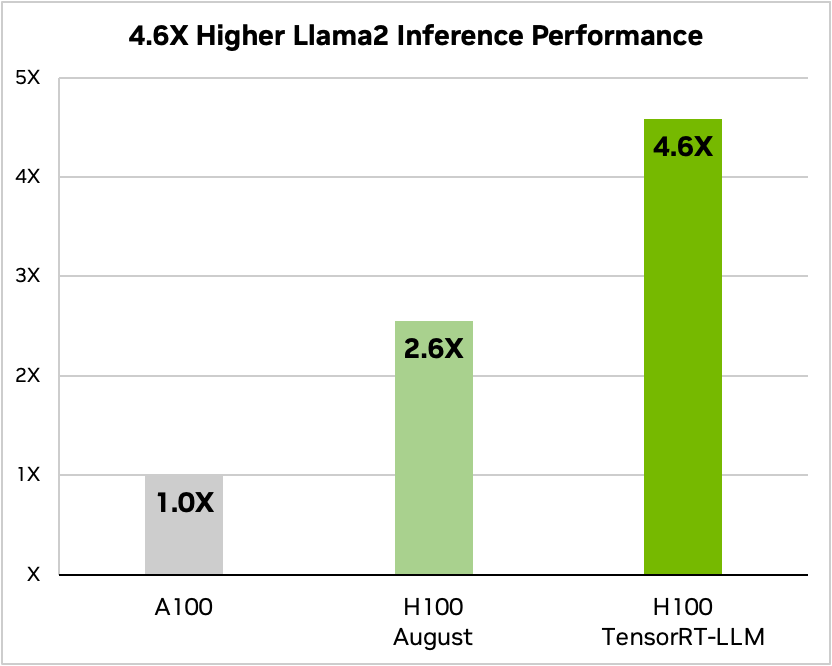

Lastly, we pass a user query to the chain and stream the result.

In [ ]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever()    #Retriever is an interface that returns documents given an unstructured query
)
result = qa_chain.invoke({"query": question})
result['result']

'ChipNeMo is a project that explores the applications of Large Language Models (LLMs) for industrial chip design. Instead of directly deploying off-the-shelf LLMs, ChipNeMo adopts domain adaptation techniques such as custom tokenizers, domain-adaptive continued pretraining, supervised fine-tuning with domain-specific instructions, and domain-adapted retrieval models. These techniques are evaluated on three selected LLM applications for chip design: an engineering assistant chatbot, EDA script generation, and bug summarization and analysis. The goal is to enable significant LLM performance improvements over general-purpose base models, reducing model size while maintaining or improving performance on a range of design tasks.'